In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from easydict import EasyDict as edict
import numpy as np

from PIL import Image, ImageDraw
from IPython.display import display

def draw_point(im_path: Path, list_points_2d): 
    im = Image.open(im_path) 
    draw = ImageDraw.Draw(im)

    point_size = 5
    point_color = (255, 0, 0)  # red
    for point in list_points_2d:
        draw.ellipse([(point[0] - point_size // 2, point[1] - point_size // 2),
                    (point[0] + point_size // 2, point[1] + point_size // 2)],
                    fill=point_color)
    return im

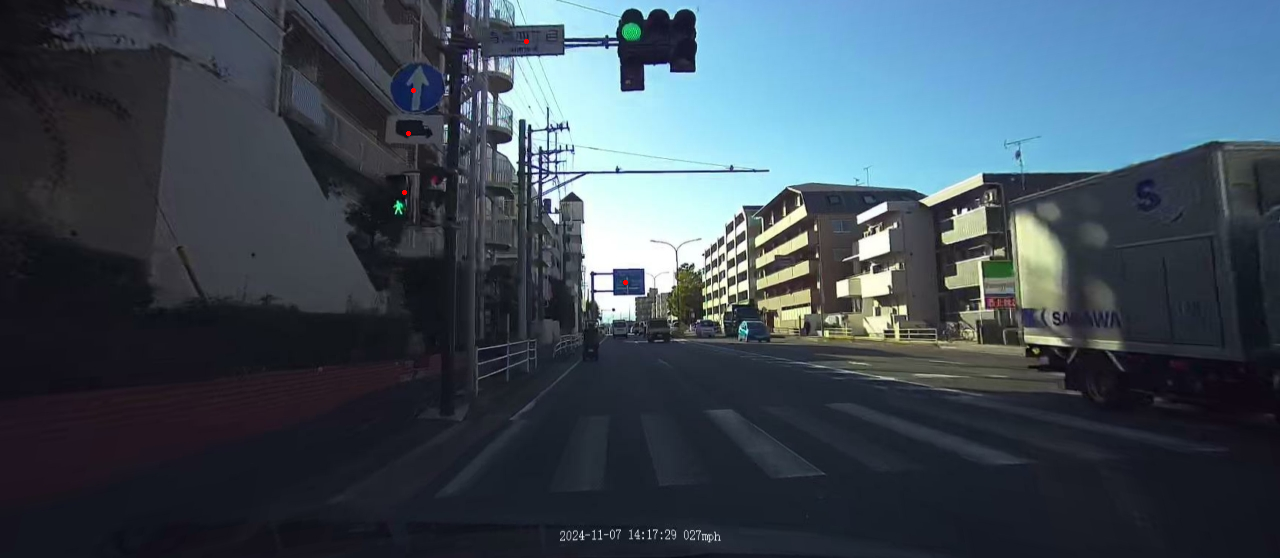

In [2]:
# Assignment: fill in the function questions  then play with diffferent image_number and change the is_distorted flag to True
# Answer the questions
#             how would you call the number d returned by the function
#             what is ecef
#             why are the pose for distorted equal to those of undistorted
#             why the intrinsics do not depend on image name
#             why does this not look good for is_distorted = True and what can we do about it

import numpy as np

def project_pinhole(p, intrinsics, pose, debug=False):
    """
    Project a 3D point using the pinhole camera model
    
    Args:
        p: A (3,1) numpy array representing a 3D point in world coordinates (ECEF)
        intrinsics: with fields fx, fy, cx, cy (camera intrinsic parameters)
        pose: with fields R (3x3 rotation matrix), t (3x1 translation vector)
              Note: t is the camera position in world coordinates
    
    Returns:
        tuple: (x_sensor, y_sensor, d) where:
               - x_sensor, y_sensor are pixel coordinates on the image sensor
               - d is the distance from camera to the point
    """
    
    # Extract rotation matrix and translation vector from pose
    R = pose['R']  # 3x3 rotation matrix from world to camera
    t = pose['t']  # 3x1 camera position in world coordinates
    
    # DEBUG: Print values to understand what's happening
    if debug:
        print(f"Point p: {p.flatten()}")
        print(f"Camera position t: {t.flatten()}")
        print(f"p - t: {(p - t).flatten()}")
    
    # Transform point from world coordinates to camera coordinates
    # According to the note in the original code: t here is equal to -Rt from the lecture
    # So we use: p_camera = R @ p + t (instead of R @ (p - t))
    p_camera = R @ p + t
    if debug:
        print(f"p_camera: {p_camera.flatten()}")
    
    # Extract coordinates in camera frame
    X_cam = p_camera[0, 0]  # X coordinate in camera frame
    Y_cam = p_camera[1, 0]  # Y coordinate in camera frame  
    Z_cam = p_camera[2, 0]  # Z coordinate in camera frame (depth)
    if debug:
        print(f"Z_cam (depth): {Z_cam}")
        print("---")
        
        # Check if point is behind the camera (negative Z)
        if Z_cam <= 0:
            # Point is behind camera or at camera plane - cannot project
            print("Point is behind camera!")
            return float('nan'), float('nan'), float('nan')
    
    # Apply perspective projection using pinhole camera model
    # Formula: u = fx * (X/Z) + cx, v = fy * (Y/Z) + cy
    x_sensor = intrinsics.fx * (X_cam / Z_cam) + intrinsics.cx
    y_sensor = intrinsics.fy * (Y_cam / Z_cam) + intrinsics.cy
    
    # Calculate distance from camera to point
    # Using Euclidean distance in 3D camera coordinates
    d = np.sqrt(X_cam**2 + Y_cam**2 + Z_cam**2)
    
    return x_sensor, y_sensor, d

assets_path = Path('3dv-short-course-images')

segment_id_1 = '275f2690-23e5-4acd-bf99-2a1a97e6e570'   # 2 dmp cameras, have dmp shapes

nexar_images = ['20241107_051651A_mp4__001154.jpg', '20241107_051651A_mp4__001160.jpg']
distorted_images = ['distorted_20241107_051651A_mp4__001154.jpg', 'distorted_20241107_051651A_mp4__001160.jpg']
undistorted_images = ['undistorted_20241107_051651A_mp4__001154.jpg', 'undistorted_20241107_051651A_mp4__001160.jpg']

camera_intrinsics = edict(
    nexar_distorted = edict(
        w=1280,
        h=720,
        camera_model='colmap_radial',
        fx=882.3212892103986,
        fy=882.3212892103986,
        cx=640.0,
        cy=360.0,
        k1=-0.3882772391716781,
        k2=0.11183503504936487
    ),
    nexar_undistorted = edict(
        w=1280,
        h=558,
        camera_model='pinhole',
        fx=636.0676579228768,
        fy=635.6408013930611,
        cx=640.0,
        cy=279.0
    )
)

pose_by_image_name = {
    'distorted_20241107_051651A_mp4__001154.jpg': {
        'R': np.array([[ 0.58879828, -0.21949033,  0.77790782],
                       [ 0.64783314, -0.44737875, -0.61657479],
                       [ 0.48335163,  0.86699265, -0.12122273]]), 
        't': np.array([[ 196574.3537559 ], [6343225.02984402],[-561172.87502357]])}, 
    'distorted_20241107_051651A_mp4__001160.jpg': {
        'R': np.array([[ 0.58887682, -0.21891042,  0.77801178],
                       [ 0.64813116, -0.44719169, -0.61639727],
                       [ 0.48285618,  0.86723574, -0.12145815]]), 
        't': np.array([[ 194548.49906685], [6343118.14276729], [-563084.05932236]])}, 
    'undistorted_20241107_051651A_mp4__001154.jpg': {
        'R': np.array([[ 0.58879828, -0.21949033,  0.77790782],
                       [ 0.64783314, -0.44737875, -0.61657479],
                       [ 0.48335163,  0.86699265, -0.12122273]]), 
         't': np.array([[ 196574.3537559 ], [6343225.02984402], [-561172.87502357]])}, 
    'undistorted_20241107_051651A_mp4__001160.jpg': {
        'R': np.array([[ 0.58887682, -0.21891042,  0.77801178],
                       [ 0.64813116, -0.44719169, -0.61639727],
                       [ 0.48285618,  0.86723574, -0.12145815]]), 
        't': np.array([[ 194548.49906685], [6343118.14276729],[-563084.05932236]])}
}

signs_3d = [
    [-3953848.2207747577, 3367515.524743535, 3690126.4256444126], 
    [-3953847.370960521, 3367514.3233560296, 3690125.512693499], 
    [-3953847.6750817653, 3367515.6303010867, 3690128.228192723], 
    [-3953847.8708120137, 3367515.0007948703, 3690126.0140610617], 
    [-3953814.475204671, 3367568.4366355096, 3690118.165392032] 
]

# p3_ecef = np.array([-3953821.0717477687, 3367498.330574915, 3690107.0067546996]).reshape(3,1)

is_distorted = False
image_number = 1     # 0,1

list_image_names = distorted_images if is_distorted else undistorted_images
intrinsics = camera_intrinsics.nexar_distorted if is_distorted else camera_intrinsics.nexar_undistorted

list_points_2d = []
for s in signs_3d:
    p3_ecef = np.array(s).reshape(3,1)
    image_name = list_image_names[1]
    image_file = assets_path/ image_name

    pose = pose_by_image_name[image_name]

    xsensor, ysensor, d = project_pinhole(p3_ecef, intrinsics, pose)
    list_points_2d.append((xsensor, ysensor))

im = draw_point(image_file, list_points_2d=list_points_2d)
display(im)

In [3]:
list_points_2d

[(413.9031186307014, 90.26562701848468),
 (404.84185895915334, 192.95870639543517),
 (526.0754645614533, 41.287099258984824),
 (408.36515765747265, 133.20847055350015),
 (625.9256166457626, 282.4587306033243)]

Image: undistorted_20241107_051651A_mp4__001154.jpg | Distorted: False


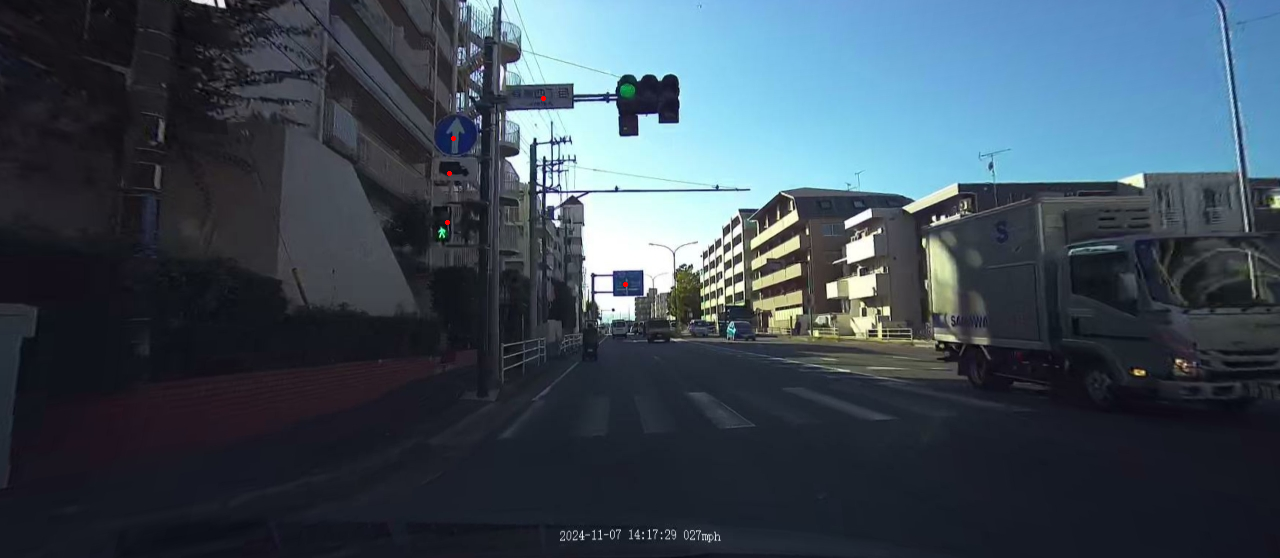

Image: undistorted_20241107_051651A_mp4__001160.jpg | Distorted: False


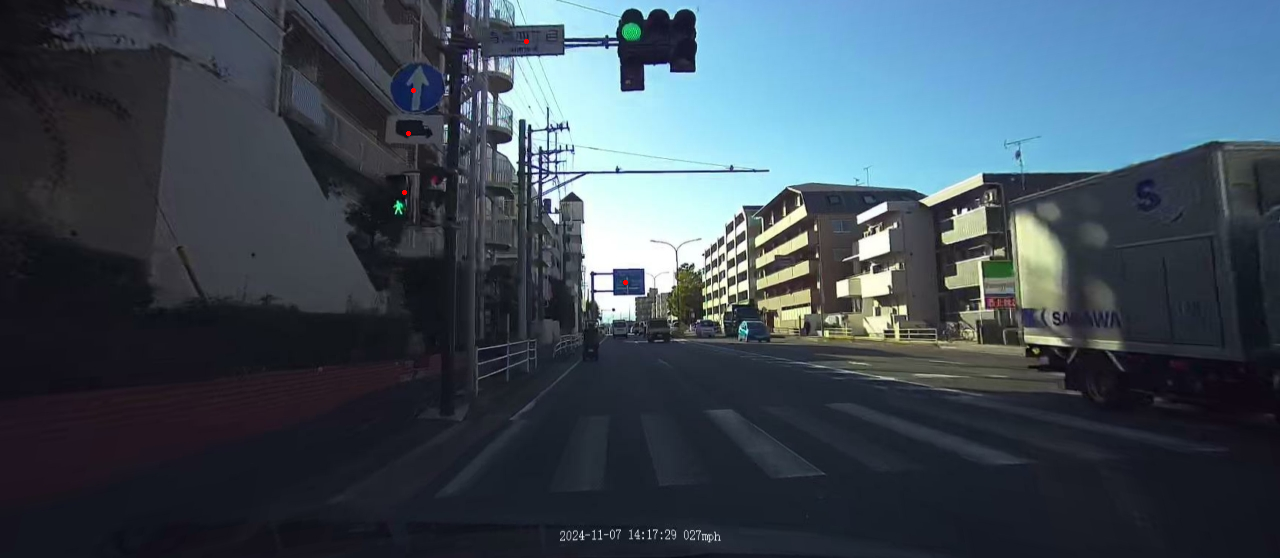

Image: distorted_20241107_051651A_mp4__001154.jpg | Distorted: True


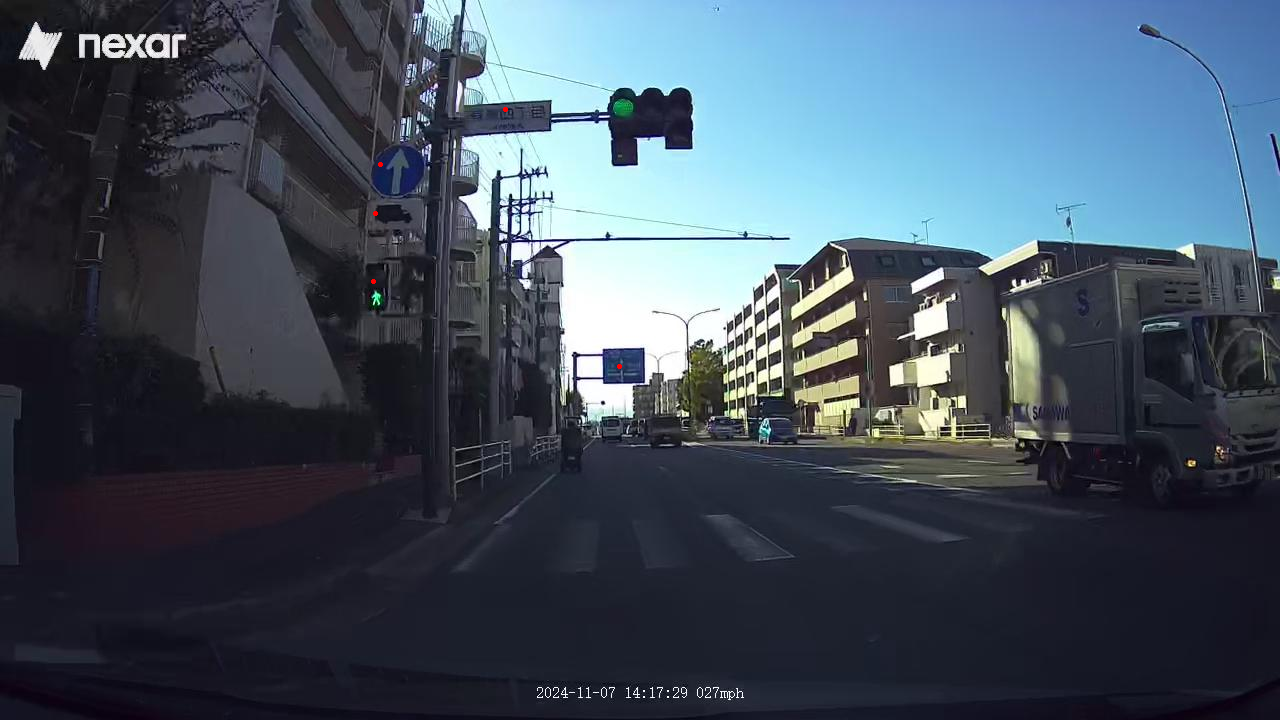

Image: distorted_20241107_051651A_mp4__001160.jpg | Distorted: True


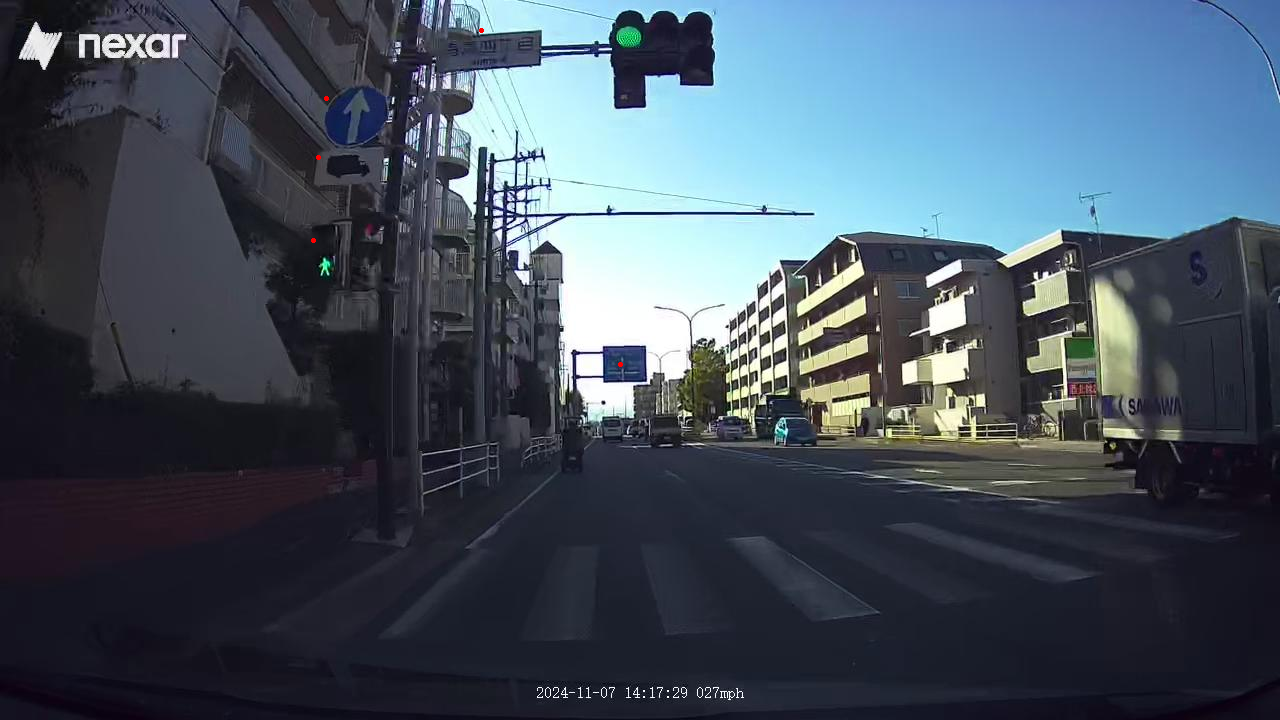

In [4]:
for is_distorted in [False, True]:
    for image_number in [0, 1]:
        list_image_names = distorted_images if is_distorted else undistorted_images
        intrinsics = camera_intrinsics.nexar_distorted if is_distorted else camera_intrinsics.nexar_undistorted

        list_points_2d = []
        for s in signs_3d:
            p3_ecef = np.array(s).reshape(3, 1)
            image_name = list_image_names[image_number]
            image_file = assets_path / image_name

            pose = pose_by_image_name[image_name]

            xsensor, ysensor, d = project_pinhole(p3_ecef, intrinsics, pose)
            list_points_2d.append((xsensor, ysensor))

        print(f"Image: {image_name} | Distorted: {is_distorted}")
        im = draw_point(image_file, list_points_2d=list_points_2d)
        display(im)


# Q&A

### 📌 Assignment Questions and Answers

#### ❓ 1. How would you call the number `d` returned by the function?
**Answer:**  
`d` is the **depth** or **Euclidean distance** from the camera to the 3D point, measured in meters.

---

#### ❓ 2. What is ECEF?
**Answer:**  
ECEF stands for **Earth-Centered, Earth-Fixed**.  
It is a global 3D coordinate system where:
- The origin is at the center of the Earth.
- X axis points toward the intersection of the Equator and Prime Meridian.
- Y axis is perpendicular to the X axis in the equatorial plane.
- Z axis goes through the North Pole.

---

#### ❓ 3. Why are the poses for distorted equal to those of undistorted?
**Answer:**  
Because the **camera pose** (position and orientation in space) does not change when distortion is corrected.  
Distortion only affects the image appearance, not the physical location or direction of the camera.

---

#### ❓ 4. Why do the intrinsics not depend on image name?
**Answer:**  
Intrinsics depend on the **camera model and lens parameters**, not on the specific image.  
All images taken with the same camera and processing type (distorted or undistorted) share the same intrinsics.

---

#### ❓ 5. Why does this not look good for `is_distorted = True`, and what can we do about it?
**Answer:**  
When `is_distorted = True`, we project using a pinhole model but the image is still distorted by lens effects.  
As a result, the 2D projection is incorrect because distortion is not compensated.

**What we can do:**
- Either undistort the image first (and use the undistorted intrinsics).
- Or apply a distortion-aware projection using distortion coefficients (`k1`, `k2`) with OpenCV’s `cv2.projectPoints` or a similar model.
